# Probabilistic chan-vese, patch-based probabilities approach
### As covered in Dahl & Dahl paper section 2.5

#### Import necessary libraries

In [0]:
import skimage
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import scipy.ndimage
import imageio
from skimage.draw import polygon2mask
%matplotlib inline
import matplotlib as mpl
mpl.rc('image', cmap='gray')

#### Define snake regularization functions. They've been provided by the lecturers in the Deformable Models lecture.

In [0]:
import scipy.interpolate

def distribute_points(snake):
    """ Distributes snake points equidistantly."""
    N = snake.shape[1]
    d = np.sqrt(np.sum((np.roll(snake, -1, axis=1)-snake)**2, axis=0)) # length of line segments
    f = scipy.interpolate.interp1d(np.r_[0, np.cumsum(d)], np.c_[snake, snake[:,0:1]])
    return(f(sum(d)*np.arange(N)/N))

def is_crossing(p1, p2, p3, p4):
    """ Check if the line segments (p1, p2) and (p3, p4) cross."""
    crossing = False
    d21 = p2 - p1
    d43 = p4 - p3
    d31 = p3 - p1
    det = d21[0]*d43[1] - d21[1]*d43[0] # Determinant
    if det != 0.0 and d21[0] != 0.0 and d21[1] != 0.0:
        a = d43[0]/d21[0] - d43[1]/d21[1]
        b = d31[1]/d21[1] - d31[0]/d21[0]
        if a != 0.0:
            u = b/a
            if d21[0] > 0:
                t = (d43[0]*u + d31[0])/d21[0]
            else:
                t = (d43[1]*u + d31[1])/d21[1]
            crossing = 0 < u < 1 and 0 < t < 1         
    return crossing

def is_counterclockwise(snake):
    """ Check if points are ordered counterclockwise."""
    return np.dot(snake[0,1:] - snake[0,:-1],
                  snake[1,1:] + snake[1,:-1]) < 0

def remove_intersections(snake):
    """ Reorder snake points to remove self-intersections.
        Arguments: snake represented by a 2-by-N array.
        Returns: snake.
    """
    pad_snake = np.append(snake, snake[:,0].reshape(2,1), axis=1)
    pad_n = pad_snake.shape[1]
    n = pad_n - 1 
    
    for i in range(pad_n - 3):
        for j in range(i + 2, pad_n - 1):
            pts = pad_snake[:,[i, i + 1, j, j + 1]]
            if is_crossing(pts[:,0], pts[:,1], pts[:,2], pts[:,3]):
                # Reverse vertices of smallest loop
                rb = i + 1 # Reverse begin
                re = j     # Reverse end
                if j - i > n // 2:
                    # Other loop is smallest
                    rb = j + 1
                    re = i + n                    
                while rb < re:
                    ia = rb % n
                    rb = rb + 1                    
                    ib = re % n
                    re = re - 1                    
                    pad_snake[:,[ia, ib]] = pad_snake[:,[ib, ia]]                    
                pad_snake[:,-1] = pad_snake[:,0]                
    snake = pad_snake[:,:-1]
    if is_counterclockwise(snake):
        return snake
    else:
        return np.flip(snake, axis=1)
    
def regularization_matrix(N, alpha, beta):
    """An NxN matrix for imposing elasticity and rigidity to snakes.
    Arguments: alpha is weigth for second derivative (elasticity),
    beta is weigth for (-)fourth derivative (rigidity)."""
    column = np.zeros(N)
    column[[-2,-1,0,1,2]] = alpha*np.array([0,1,-2,1,0]) + beta*np.array([-1,4,-6,4,-1])
    A = scipy.linalg.toeplitz(column)
    return(scipy.linalg.inv(np.eye(N)-A))

def smooth_snake(s, alpha=5):
    N = s.shape[0]
    return np.matmul(regularization_matrix(N,alpha,0),s)

#### Circular snake initialization function

In [0]:
def create_circle_snake(cx, cy, r, l):
    temp = np.linspace(0, 2 * np.pi, l)
    x = r * np.cos(temp) + cx
    y = r * np.sin(temp) + cy
    
    return np.c_[x, y]

def plot_snake(s):
  s_to_plot = np.vstack((s, s[0,:]))
  plt.plot(s_to_plot[:,0], s_to_plot[:,1], c='red', linewidth=2)

#### Feature extraction functions (provided by the lecturers)

In [0]:
def get_gauss_feat_im(im, sigma=1, normalize=False):
      
    r,c = im.shape
    imfeat = np.zeros((r,c,15))
    imfeat[:,:,0] = scipy.ndimage.gaussian_filter(im,sigma,order=0)
    imfeat[:,:,1] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,1])
    imfeat[:,:,2] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,0])
    imfeat[:,:,3] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,2])
    imfeat[:,:,4] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,1])
    imfeat[:,:,5] = scipy.ndimage.gaussian_filter(im,sigma,order=[2,0])
    imfeat[:,:,6] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,3])
    imfeat[:,:,7] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,2])
    imfeat[:,:,8] = scipy.ndimage.gaussian_filter(im,sigma,order=[2,1])
    imfeat[:,:,9] = scipy.ndimage.gaussian_filter(im,sigma,order=[3,0])
    imfeat[:,:,10] = scipy.ndimage.gaussian_filter(im,sigma,order=[0,4])
    imfeat[:,:,11] = scipy.ndimage.gaussian_filter(im,sigma,order=[1,3])
    imfeat[:,:,12] = scipy.ndimage.gaussian_filter(im,sigma,order=[2,2])
    imfeat[:,:,13] = scipy.ndimage.gaussian_filter(im,sigma,order=[3,1])
    imfeat[:,:,14] = scipy.ndimage.gaussian_filter(im,sigma,order=[4,0])
    
    if normalize:
        imfeat -= np.mean(imfeat, axis=(0,1))
        imfeat *= (1/np.std(imfeat, axis=(0,1)))
    
    return imfeat

def im2col(im, patch_size=[3,3], stepsize=1):
    """Rearrange image patches into columns
    Arguments:
        image: a 2D image, shape (r,c).
        patch size: size of extracted paches.
        stepsize: patch step size.
    Returns:
        patches: a 2D array which in every column has a patch associated 
            with one image pixel. For stepsize 1, number of returned column 
            is (r-patch_size[0]+1)*(c-patch_size[0]+1) due to bounary. The 
            length of columns is pathc_size[0]*patch_size[1].
    """
    
    r,c = im.shape
    s0, s1 = im.strides    
    nrows =r-patch_size[0]+1
    ncols = c-patch_size[1]+1
    shp = patch_size[0],patch_size[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(im, shape=shp, strides=strd)
    return out_view.reshape(patch_size[0]*patch_size[1],-1)[:,::stepsize]


def ndim2col(im, block_size=[3,3], stepsize=1):
    """Rearrange image blocks into columns for N-D image (e.g. RGB image)"""""
    if(im.ndim == 2):
        return im2col(im, block_size, stepsize)
    else:
        r,c,l = im.shape
        patches = np.zeros((l*block_size[0]*block_size[1],
                            (r-block_size[0]+1)*(c-block_size[1]+1)))
        for i in range(l):
            patches[i*block_size[0]*block_size[1]:(i+1)*block_size[0]*block_size[1],
                    :] = im2col(im[:,:,i],block_size,stepsize)
        return patches

def ind2labels(ind):
    """ Helper function for transforming uint8 image into labeled image."""
    return np.unique(ind, return_inverse=True)[1].reshape(ind.shape)

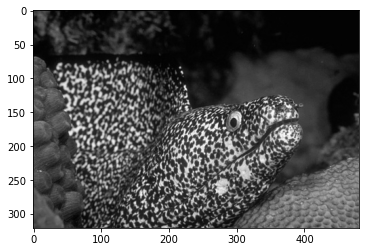

In [5]:
filename = './164074.jpg'
#filename= './train_C_image.png'
I = imageio.imread(filename, as_gray=True).astype(np.uint8)

plt.imshow(I)

#### Initialize a circular snake

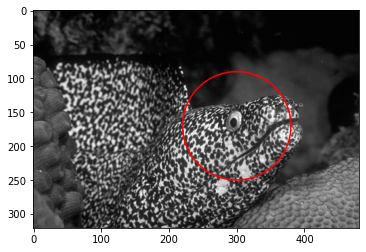

In [6]:
s = create_circle_snake(300, 170, 80, 150)
plt.imshow(I)
plt.plot(s[:,0], s[:,1], c='red')

#### Create a function to transform image I, given snake s, into P_in and P_out probability images, according to section 2.5 of the Dahl & Dahl paper.
- P_in represents the likelihood of each pixel in I belonging to the inside region.
- P_out represents the likelihood of each pixel in I belonging to the outside region.

In [0]:
def get_S_and_B(I, cluster_count, patch_size=3):

    rows = I.shape[0] - patch_size + 1
    cols = I.shape[1] - patch_size + 1

    features = im2col(I, patch_size=[patch_size, patch_size]).T
    nr_keep = int(np.round((features.shape[0] * features.shape[1]) / 10.0)) # number of features randomly picked for clustering
    keep_indices = np.random.permutation(np.arange(features.shape[0]))[:nr_keep]

    features_subset = features[keep_indices,:]

    nr_clusters = cluster_count # number of feature clusters
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=nr_clusters, batch_size=2*nr_clusters)
    kmeans.fit(features_subset)
    assignment = kmeans.labels_
    S = kmeans.predict(features).reshape((rows, cols))
    
    pixel_count = S.shape[0] * S.shape[1]
    
    # Create matrix of i rows of 0..cluster_count values
    value_range = np.arange(cluster_count, dtype=np.uint16)
    value_range_matrix = np.multiply(value_range, np.ones((pixel_count, cluster_count), dtype=np.uint16))
    
    # Create matrix of cluster_count columns of S_flat vectors
    s_flat = S.ravel()
    s_matrix = np.multiply(s_flat, np.ones((pixel_count, cluster_count), dtype=np.uint16).T).T

    B = (value_range_matrix == s_matrix).astype(np.bool)

    return (S, B)

def get_pin_pout(s, S, B):

    in_mask = polygon2mask(S.shape, s).ravel().astype(np.bool)
    out_mask = 1 - in_mask
    
    A_in = np.sum(in_mask).astype(np.float32)
    A_out = np.sum(out_mask).astype(np.float32)

    f_in = (B.T.astype(np.float32) @ in_mask) / A_in
    p_in = f_in / f_in.sum()    
    P_in = p_in[S]
    
    f_out = (B.T.astype(np.float32) @ out_mask) / A_out
    p_out = f_out / f_out.sum()
    P_out = p_out[S]
        
    return (P_in, P_out)

In [0]:
def get_S_and_B_and_clusts(I, cluster_count, patch_size=3):

    rows = I.shape[0] - patch_size + 1
    cols = I.shape[1] - patch_size + 1

    features = im2col(I, patch_size=[patch_size, patch_size]).T
    nr_keep = int(np.round((features.shape[0] * features.shape[1]) / 10.0)) # number of features randomly picked for clustering
    keep_indices = np.random.permutation(np.arange(features.shape[0]))[:nr_keep]

    features_subset = features[keep_indices,:]

    nr_clusters = cluster_count # number of feature clusters
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=nr_clusters, batch_size=2*nr_clusters)
    kmeans.fit(features_subset)
    assignment = kmeans.labels_
    S = kmeans.predict(features).reshape((rows, cols))
    
    pixel_count = S.shape[0] * S.shape[1]
    
    # Create matrix of i rows of 0..cluster_count values
    value_range = np.arange(cluster_count, dtype=np.uint16)
    value_range_matrix = np.multiply(value_range, np.ones((pixel_count, cluster_count), dtype=np.uint16))
    
    # Create matrix of cluster_count columns of S_flat vectors
    s_flat = S.ravel()
    s_matrix = np.multiply(s_flat, np.ones((pixel_count, cluster_count), dtype=np.uint16).T).T

    B = (value_range_matrix == s_matrix).astype(np.bool)

    return S, B, kmeans.cluster_centers_

In [0]:
def plot_clust_im(clusts):
  
  clust_side = int(np.sqrt(clusts.shape[1]))
  im = np.zeros((10*clust_side+9, 10*clust_side+9))

  for row in range(10):
    for col in range(10):
      clust = clusts[row*10+col,:].reshape((clust_side, clust_side))
      row_start = row*clust_side + row
      row_end = row_start + clust_side
      col_start = col * clust_side + col
      col_end = col_start + clust_side

      im[row_start:row_end, col_start:col_end] = clust

  plt.imshow(im)
  plt.axis('off')

In [0]:
def plot_pin_pout(s, S, B, clust_side):

    in_mask = polygon2mask(S.shape, s).ravel().astype(np.bool)
    out_mask = 1 - in_mask
    
    A_in = np.sum(in_mask).astype(np.float32)
    A_out = np.sum(out_mask).astype(np.float32)

    clust_indices = np.unique(S)

    f_in = (B.T.astype(np.float32) @ in_mask) / A_in
    p_in = f_in / f_in.sum()    
    P_in = p_in[clust_indices]
    
    f_out = (B.T.astype(np.float32) @ out_mask) / A_out
    p_out = f_out / f_out.sum()
    P_out = p_out[clust_indices]

    P = P_in - P_out
    P = P / np.abs(P).max()

    print(P.max())
    print(P.min())

    im = np.zeros((10*clust_side+9, 10*clust_side+9, 3))

    for row in range(10):
      for col in range(10):
        clust = (P)[row*10 + col]
        row_start = row*clust_side + row
        row_end = row_start + clust_side
        col_start = col * clust_side + col
        col_end = col_start + clust_side

        if clust > 0:
          im[row_start:row_end, col_start:col_end, 0] = 1
          im[row_start:row_end, col_start:col_end, 1:3] = 1-clust
        elif clust < 0:
          im[row_start:row_end, col_start:col_end, 2] = 1
          im[row_start:row_end, col_start:col_end, 0:2] = 1+clust

    plt.imshow(im)
    plt.axis('off')

#### Plot the difference between P_in and P_out, just to show off how good this approach can be for segmentation.

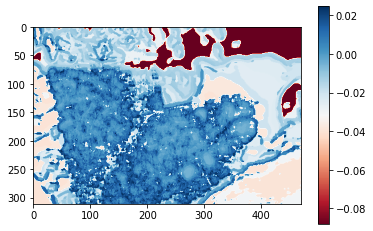

In [11]:
S, B = get_S_and_B(I, 100, patch_size=11)

P_in, P_out = get_pin_pout(s, S, B)

plt.imshow(P_in - P_out, cmap='RdBu')
plt.colorbar()

#### Create the snake update function. It's based on equation 6.3 of the lecture note. The only major difference is that the external forces in line 9..10 are calculated according to the section 2.4, equation 15 of the Dahl & Dahl paper.

In [0]:
def update_snake(s, I, patch_size=3, tau=20, alph=0.1, iterations=10):
    
    S, B = get_S_and_B(I, 100, patch_size=patch_size)

    for i in range(iterations):
        
        # One distinct snake update step
        
        # Get probability images
        P_in, P_out = get_pin_pout(s, S, B)
        P = P_in - P_out

        # Clip snake points that go out of the image
        s[:,0] = np.clip(s[:,0], 0, P.shape[1]-1)
        s[:,1] = np.clip(s[:,1], 0, P.shape[0]-1)
            
        # Calculate external forces from probability images
        forces = P[s[:,1].astype(int), s[:,0].astype(int)]
        forces = np.diag(forces)
        
        # Calculate vector of snake normals
        pre = np.vstack((s[-1], s[:-1]))
        nex = np.vstack((s[1:], s[0]))
        normals = pre - nex
        normals = np.c_[-normals[:,1], normals[:,0]]
        norms_of_normals = np.linalg.norm(normals, axis=1)  # :D :D
        normals = normals / norms_of_normals[:, None]
        
        # Calculate displacement
        displacement = tau * (forces @ normals)
        
        # Displace the snake
        s = s + displacement
        
        # Distribute snake points so they're equal distances away from each other.
        s = distribute_points(s)
        
        # Remove intersections in the snake if there're any.
        s = remove_intersections(s.T).T
        
        # Apply regularization - smooth the snake.
        s = smooth_snake(s, alpha=alph)

        # Clip snake points that go out of the image
        s[:,0] = np.clip(s[:,0], 0, P.shape[1]-1)
        s[:,1] = np.clip(s[:,1], 0, P.shape[0]-1)
    
    return s

#### Example: initialize circular snake in image I

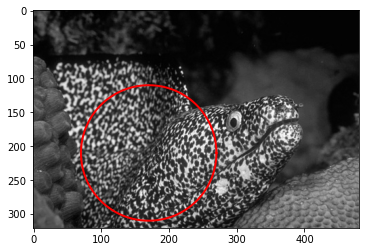

In [31]:
s = create_circle_snake(170, 210, 100, 150)
plt.imshow(I)
plot_snake(s)

0.19741539006655898
-1.0


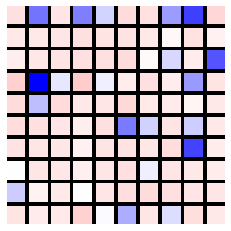

In [56]:
S, B, clusts = get_S_and_B_and_clusts(I, 100, patch_size=5)
plot_pin_pout(s, S, B, 5)

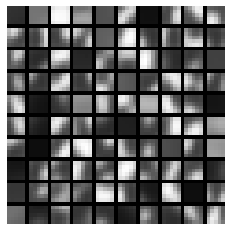

In [33]:
plot_clust_im(clusts)

#### Example: Move the snake
- with displacement multiplier Tau = 1000
- with regularization coefficient alpha = 1
- in 80 iterations

**WARNING** 
It's slow...

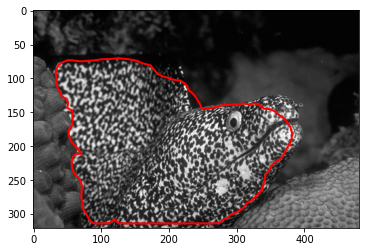

In [40]:
s1 = update_snake(s, I, patch_size=7, tau=500, alph=1.1, iterations=200)
plt.imshow(I)
plot_snake(s1)

0.13937556115562924
-1.0


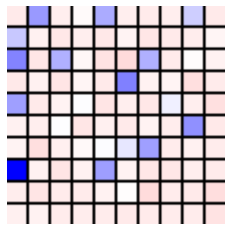

In [55]:
S, B, clusts = get_S_and_B_and_clusts(I, 100, patch_size=7)
plot_pin_pout(s1, S, B, 7)

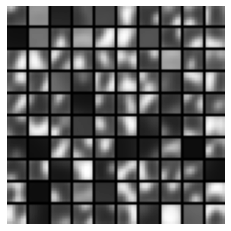

In [42]:
plot_clust_im(clusts)

#### ... Of course, the parameters can be fine-tuned to achieve better results.

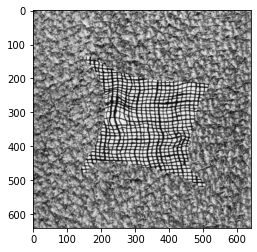

In [43]:
I2 = skimage.io.imread('overlap_test.png')
plt.imshow(I2)

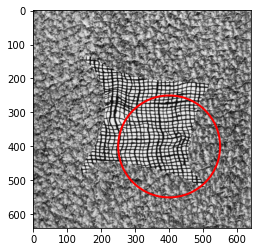

In [44]:
s2 = create_circle_snake(400, 400, 150, 200)
plt.imshow(I2)
plot_snake(s2)

1.0
-0.6583195814924914


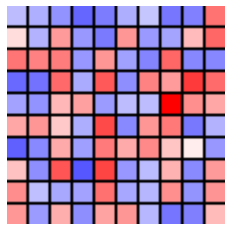

In [47]:
S, B, clusts = get_S_and_B_and_clusts(I2, 100, patch_size=7)
plot_pin_pout(s2, S, B, 7)

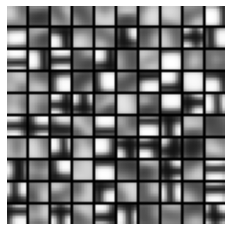

In [48]:
plot_clust_im(clusts)

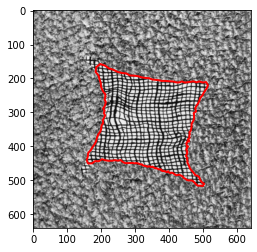

In [49]:
s3 = update_snake(s2, I2, patch_size=7, tau=200, alph=0.2, iterations=300)
plt.imshow(I2)
plot_snake(s3)

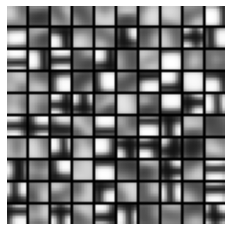

In [52]:
plot_clust_im(clusts)
clust_side = int(np.sqrt(clusts.shape[1]))
im = np.array((clust_side*10, clust_side*10))

1.0
-0.7328354762078142


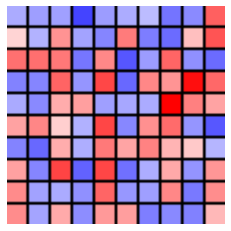

In [53]:
plot_pin_pout(s3, S, B, 7)